# DA Test for Ocare
Answered by Tanat Piumsuwan

### import libraries

In [95]:
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from collections import defaultdict

Given the Patient Value & Care Insight Analysis - the following patient dataset from a healthcare clinic, each row represents a patient's hospital admission, including demographics, medical condition, and billing data. 

In [96]:
df = pd.read_csv("healthcare_dataset.csv")
df.head()

Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medication  \
0    18856.281306          328         Urgent     2024-02-02  Paracetamol   
1    33643.327287          265      Emergency     2019-08-26    Ibuprofen   
2    27955.096079          205      Emergency     2022-10-07      Aspirin   
3    37909.782410          450       Elective     2020-12-18    Ibuprofen   
4    14238.317814          458         Urgent     2022-10-09   Penicillin   

   Test Results  
0        Normal  
1  Inconclusive  
2        Normal  
3      Abnormal  
4      Abnormal

In [97]:
df.describe()

Age  Billing Amount   Room Number
count  55500.000000    55500.000000  55500.000000
mean      51.539459    25539.316097    301.134829
std       19.602454    14211.454431    115.243069
min       13.000000    -2008.492140    101.000000
25%       35.000000    13241.224652    202.000000
50%       52.000000    25538.069376    302.000000
75%       68.000000    37820.508436    401.000000
max       89.000000    52764.276736    500.000000

----
#### 1. Most Valuable Patients
Identify the top 3 patients by Billing Amount. Clean the names for proper capitalization (e.g., EMILY JOHNSOn → Emily Johnson) before displaying the result. 

In [98]:
# Clean names
df['Name'] = df["Name"].str.title()
df['Doctor'] = df["Doctor"].str.title()

# Get top patients
top_patients = df.sort_values(by='Billing Amount', ascending=False).head(3)


print(top_patients)


                Name  Age  Gender Blood Type Medical Condition  \
36349  Todd Carrillo   51  Female         A+      Hypertension   
51313    Karen Kline   74  Female        AB+            Cancer   
34613    Karen Kline   79  Female        AB+            Cancer   

      Date of Admission             Doctor          Hospital  \
36349        2023-09-08   Kathleen Griffin     Griffin Group   
51313        2021-06-19  Dr. Joseph Gordon  Hernandez-Morton   
34613        2021-06-19  Dr. Joseph Gordon  Hernandez-Morton   

      Insurance Provider  Billing Amount  Room Number Admission Type  \
36349         Blue Cross    52764.276736          209       Elective   
51313   UnitedHealthcare    52373.032374          181         Urgent   
34613   UnitedHealthcare    52373.032374          181         Urgent   

      Discharge Date  Medication  Test Results  
36349     2023-10-04   Ibuprofen        Normal  
51313     2021-07-03  Penicillin  Inconclusive  
34613     2021-07-03  Penicillin  Inconclu

The top three valuable patients are:

In [99]:
print(top_patients[['Name', 'Billing Amount']])

                Name  Billing Amount
36349  Todd Carrillo    52764.276736
51313    Karen Kline    52373.032374
34613    Karen Kline    52373.032374


Extra for latter parts: Check if patients names are 100% unique

In [100]:
df["Name"].unique().shape

(40235,)

There are patients with repeated names: we may further check if patients with same name are the same person having follow up cases by looking at admission/discharge dates later and other attributes later.

----
#### Insight Discovery
Based on the small dataset: What medical conditions are associated with higher billing amounts? Are there any patterns in admission type or test results that the hospital should be aware of?  


First, check for follow up cases, my first four main conditions are
1. Two or more instances has same patient names with same gender and blood type
2. Such instances have non-overlapping admission/discharge dates
3. To be considered a follow-up case, the medical condition must be the same.
I will consider patient age later.

In [101]:
# Convert admission/discharge to datetime if not already
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# Prepare list for follow-up pairs
followups = []

# Sort for easier processing
df_sorted = df.sort_values(['Name', 'Date of Admission']).reset_index(drop=True)

for name, group in df_sorted.groupby('Name'):
    if len(group) < 2:
        continue

    n_visits = len(group)
    for i in range(n_visits):
        for j in range(i + 1, n_visits):
            visit1 = group.iloc[i]
            visit2 = group.iloc[j]

            # Condition 1: Same gender and blood type
            if (visit1['Gender'] != visit2['Gender']) or (visit1['Blood Type'] != visit2['Blood Type']):
                continue

            # Condition 2: Non-overlapping admission/discharge dates
            if not (visit1['Discharge Date'] <= visit2['Date of Admission'] or visit2['Discharge Date'] <= visit1['Date of Admission']):
                continue

            # Condition 3: Same medical condition
            if visit1['Medical Condition'] != visit2['Medical Condition']:
                continue

            # This pair is a follow-up case
            followups.append({
                'Name': name,
                'Medical Condition': visit1['Medical Condition'],

                'Admission Type 1': visit1['Admission Type'],
                'Admission Type 2': visit2['Admission Type'],

                'Medication 1': visit1['Medication'],
                'Medication 2': visit2['Medication'],

                'Doctor 1': visit1['Doctor'],
                'Doctor 2': visit2['Doctor'],

                'Hospital 1': visit1['Hospital'],
                'Hospital 2': visit2['Hospital'],

                'Insurance Provider 1': visit1['Insurance Provider'],
                'Insurance Provider 2': visit2['Insurance Provider'],

                'Blood Type': visit1['Blood Type'],
                'Gender': visit1['Gender'],

                'Age 1': visit1['Age'],
                'Age 2': visit2['Age'],

                'Visit 1 Admission': visit1['Date of Admission'],
                'Visit 1 Discharge': visit1['Discharge Date'],

                'Visit 2 Admission': visit2['Date of Admission'],
                'Visit 2 Discharge': visit2['Discharge Date']
            })

followups_df = pd.DataFrame(followups)


In [102]:
followups_df.shape

(228, 20)

In [103]:
followups_df

Name Medical Condition Admission Type 1 Admission Type 2  \
0    Amanda Rodriguez      Hypertension           Urgent           Urgent   
1       Amanda Spears      Hypertension         Elective        Emergency   
2          Amber Diaz      Hypertension           Urgent        Emergency   
3         Amber Jones          Diabetes         Elective           Urgent   
4         Amber Jones          Diabetes         Elective           Urgent   
..                ...               ...              ...              ...   
223   Victoria Miller           Obesity         Elective         Elective   
224     William Myers      Hypertension           Urgent           Urgent   
225     William Smith         Arthritis           Urgent           Urgent   
226  William Williams      Hypertension        Emergency         Elective   
227    Zachary Garcia      Hypertension        Emergency        Emergency   

    Medication 1 Medication 2         Doctor 1          Doctor 2  \
0     Penicillin  Paracetamol  Jessica Fischer     Oscar Stewart   
1    Paracetamol  Paracetamol  Benjamin French  Timothy Thompson   
2      Ibuprofen  Paracetamol       Adam Horne    Brandon Garcia   
3     Penicillin      Lipitor     Annette Hall        Marcus Roy   
4     Penicillin      Lipitor     Annette Hall        Marcus Roy   
..           ...          ...              ...               ...   
223   Penicillin   Penicillin       Paula Ruiz    Isaac Peck Dds   
224   Penicillin  Paracetamol      Mariah Cook   Michael Michael   
225      Aspirin      Lipitor   David Thompson    Jeffery Foster   
226  Paracetamol   Penicillin     Eric Russell   Amanda Harrison   
227      Lipitor    Ibuprofen   Eduardo Murphy   Andrea Sullivan   

                      Hospital 1                 Hospital 2  \
0                  Hill Sons and                Wheeler Inc   
1                   Johnson-Kerr  and Brown Anderson, Moyer   
2               Gutierrez-Turner     and Turner, Zhang Love   
3                     Macias LLC             Ballard-Valdez   
4                     Macias LLC             Ballard-Valdez   
..                           ...                        ...   
223                     Hall Ltd   and Mcguire Smith, Smith   
224                   Chan-Brown   Johnson and Jones Horne,   
225       May, and Wagner Cooley  Lowe Zavala and Mcdonald,   
226             Perkins-Gonzalez               Sullivan Ltd   
227  and Arnold Johnson, Edwards                 Luna-Jones   

    Insurance Provider 1 Insurance Provider 2 Blood Type  Gender  Age 1  \
0               Medicare             Medicare         O-    Male     40   
1       UnitedHealthcare           Blue Cross         A-  Female     27   
2             Blue Cross                Cigna         B-  Female     67   
3               Medicare     UnitedHealthcare         B+  Female     79   
4               Medicare     UnitedHealthcare         B+  Female     79   
..                   ...                  ...        ...     ...    ...   
223                Cigna     UnitedHealthcare         O-    Male     59   
224                Aetna                Aetna         A-    Male     77   
225                Aetna           Blue Cross         A-  Female     46   
226                Cigna                Aetna        AB-    Male     69   
227     UnitedHealthcare             Medicare         A+  Female     33   

     Age 2 Visit 1 Admission Visit 1 Discharge Visit 2 Admission  \
0       36        2019-08-18        2019-09-14        2020-06-03   
1       31        2021-03-14        2021-03-16        2023-05-13   
2       58        2023-01-24        2023-02-12        2023-11-13   
3       80        2021-01-02        2021-01-13        2023-04-09   
4       81        2021-01-02        2021-01-13        2023-04-09   
..     ...               ...               ...               ...   
223     27        2020-03-26        2020-04-12        2023-02-09   
224     26        2020-07-16        2020-08-05        2024-02-27   
225  

Without age constraint, we have only 228 possible instances to be follow up cases. Let's add that age discrepancy should correlates to the differences in previous admission vs new admission dates. To elaborate, the same patient could not ages 3 years if the two admission are in the same year. They also should not age less in the second admission.

In [104]:
from datetime import timedelta

followups = []

df_sorted = df.sort_values(['Name', 'Date of Admission']).reset_index(drop=True)

for name, group in df_sorted.groupby('Name'):
    if len(group) < 2:
        continue

    n_visits = len(group)
    for i in range(n_visits):
        for j in range(i + 1, n_visits):
            visit1 = group.iloc[i]
            visit2 = group.iloc[j]

            # Condition 1: Same gender and blood type
            if (visit1['Gender'] != visit2['Gender']) or (visit1['Blood Type'] != visit2['Blood Type']):
                continue

            # Condition 2: Non-overlapping admission/discharge dates
            if not (visit1['Discharge Date'] <= visit2['Date of Admission'] or visit2['Discharge Date'] <= visit1['Date of Admission']):
                continue

            # Condition 3: Same medical condition
            if visit1['Medical Condition'] != visit2['Medical Condition']:
                continue

            # New Condition 1: Age difference should correlate with admission date difference
            # New Condition 2: Age 1 must be less than Age 2
            if visit2['Age'] <= visit1['Age']:
                continue

            # New Condition: Age difference should correlate with admission date difference
            days_diff = abs((visit2['Date of Admission'] - visit1['Date of Admission']).days)
            years_diff = days_diff / 365.25  # approximate fractional years
            age_diff = abs(visit2['Age'] - visit1['Age'])

            tolerance = 1.0  # allowable deviation in years

            if abs(age_diff - years_diff) > tolerance:
                continue

            # This pair is a follow-up case
            followups.append({
                'Name': name,
                'Medical Condition': visit1['Medical Condition'],

                'Admission Type 1': visit1['Admission Type'],
                'Admission Type 2': visit2['Admission Type'],

                'Medication 1': visit1['Medication'],
                'Medication 2': visit2['Medication'],

                'Doctor 1': visit1['Doctor'],
                'Doctor 2': visit2['Doctor'],

                'Hospital 1': visit1['Hospital'],
                'Hospital 2': visit2['Hospital'],

                'Insurance Provider 1': visit1['Insurance Provider'],
                'Insurance Provider 2': visit2['Insurance Provider'],

                'Blood Type': visit1['Blood Type'],
                'Gender': visit1['Gender'],

                'Age 1': visit1['Age'],
                'Age 2': visit2['Age'],

                'Visit 1 Admission': visit1['Date of Admission'],
                'Visit 1 Discharge': visit1['Discharge Date'],

                'Visit 2 Admission': visit2['Date of Admission'],
                'Visit 2 Discharge': visit2['Discharge Date']
            })

followups_df = pd.DataFrame(followups)


In [105]:
followups_df 

Name Medical Condition Admission Type 1 Admission Type 2  \
0       Amber Jones          Diabetes         Elective           Urgent   
1      Angela Jones          Diabetes         Elective         Elective   
2        Billy Ford         Arthritis        Emergency        Emergency   
3     Donald Murphy          Diabetes        Emergency        Emergency   
4     Joseph Harris          Diabetes           Urgent         Elective   
5   Joseph Thompson         Arthritis        Emergency         Elective   
6  Michael Williams          Diabetes           Urgent           Urgent   
7     Nicholas Boyd            Asthma           Urgent         Elective   
8      Ryan Johnson         Arthritis           Urgent        Emergency   
9    Zachary Garcia      Hypertension        Emergency        Emergency   

  Medication 1 Medication 2            Doctor 1            Doctor 2  \
0   Penicillin      Lipitor        Annette Hall          Marcus Roy   
1      Aspirin   Penicillin  Virginia Wilkinson     Benjamin Palmer   
2  Paracetamol      Aspirin    Kimberly Bernard       Ryan Stephens   
3   Penicillin   Penicillin      Michelle Sloan         Pam Johnson   
4    Ibuprofen      Lipitor    Elizabeth Sawyer          Mary Smith   
5      Lipitor      Lipitor     David Alexander         James Allen   
6      Aspirin    Ibuprofen     Jared Rasmussen          Sarah King   
7      Lipitor      Lipitor      Pamela Pacheco     Sarah Grant Dds   
8    Ibuprofen  Paracetamol    Miranda Mcdowell  Christopher Miller   
9      Lipitor    Ibuprofen      Eduardo Murphy     Andrea Sullivan   

                     Hospital 1                     Hospital 2  \
0                    Macias LLC                 Ballard-Valdez   
1    Miller Green Calderon, and                  Gonzalez-Cole   
2  and Burns, Hernandez Edwards                     Inc Hudson   
3                 Wolf Sons and  Sullivan Henderson Lloyd, and   
4                   Roy-Johnson                Spencer-Bradley   
5                   Higgins Ltd                  Barnes-Vargas   
6      and Harris Brewer, Young      Medina, and Forbes Arnold   
7                   Booth-Jones                   Vasquez-King   
8   Smith Palmer, and Rodriguez             and Gutierrez Sons   
9   and Arnold Johnson, Edwards                     Luna-Jones   

  Insurance Provider 1 Insurance Provider 2 Blood Type  Gender  Age 1  Age 2  \
0             Medicare     UnitedHealthcare         B+  Female     79     81   
1                Aetna     UnitedHealthcare        AB-  Female     65     69   
2                Cigna                Cigna         A+    Male     57     58   
3     UnitedHealthcare                Cigna         A+    Male     39     40   
4           Blue Cross             Medicare         O+  Female     23     25   
5           Blue Cross     UnitedHealthcare         O-  Female     20     21   
6     UnitedHealthcare                Cigna        AB-    Male     47     49   
7             Medicare             Medicare         O+  Female     26     27   
8             Medicare     UnitedHealthcare         O+    Male     35     38   
9     UnitedHealthcare             Medicare         A+  Female     33     35   

  Visit 1 Admission Visit 1 Discharge Visit 2 Admission Visit 2 Discharge  
0        2021-01-02        2021-01-13        2023-04-09        2023-05-06  
1        2019-07-06        2019-07-26        2023-02-22        2023-02-27  
2        2022-02-11        2022-03-07        2022-09-04        2022-09-11  
3        2022-02-04        2022-03-06        2023-11-11        2023-11-28  
4        2022-01-25        2022-01-29        2023-06-29        2023-07-02  
5        2020-05-10        2020-05-23        2020-07-27        2020-08-24  
6        2020-12-25        2020-12-27        2023-03-29        2023-04-06  
7        2022-08-28        2022-09-24        2023-02-16        2023-03-17  
8        2020-05-02        2020-05-25        2023-12-01        2023-12-22  
9        2021-05-08        2021-05-24  

For the available data, we may conclude that there are possibility of 9 patients each with two admissions that could be considered follow-ups. This means compared to the larger samples of 55500 patients, I may ignore this and estimate that all admission record are independent for now. 
Next, I will explore data distributions and perform association tests. For association test, will use correlation for numerical values (extract date into years month day first), and ANOVA for categorical values. However, patient's name is obviously should not be considered for association tests. Starts by reprocessing the date data:

In [106]:
df.drop(columns = ["Name"], inplace = True)

# Extract separate date components for Admission
df['Admission Year'] = df['Date of Admission'].dt.year
df['Admission Month'] = df['Date of Admission'].dt.month
df['Admission DayOfWeek'] = df['Date of Admission'].dt.dayofweek  # Monday=0, Sunday=6
df['Admission DayOfYear'] = df['Date of Admission'].dt.dayofyear
df['Days Since First Admission'] = (df['Date of Admission'] - df['Date of Admission'].min()).dt.days

# Extract separate date components for Discharge
df['Discharge Year'] = df['Discharge Date'].dt.year
df['Discharge Month'] = df['Discharge Date'].dt.month
df['Discharge DayOfWeek'] = df['Discharge Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Discharge DayOfYear'] = df['Discharge Date'].dt.dayofyear
df['Days Since First Discharge'] = (df['Discharge Date'] - df['Discharge Date'].min()).dt.days

# Calculate total days admitted (length of stay)
df['Total Days Admitted'] = (df['Discharge Date'] - df['Date of Admission']).dt.days


Then roughly check the distributions:

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


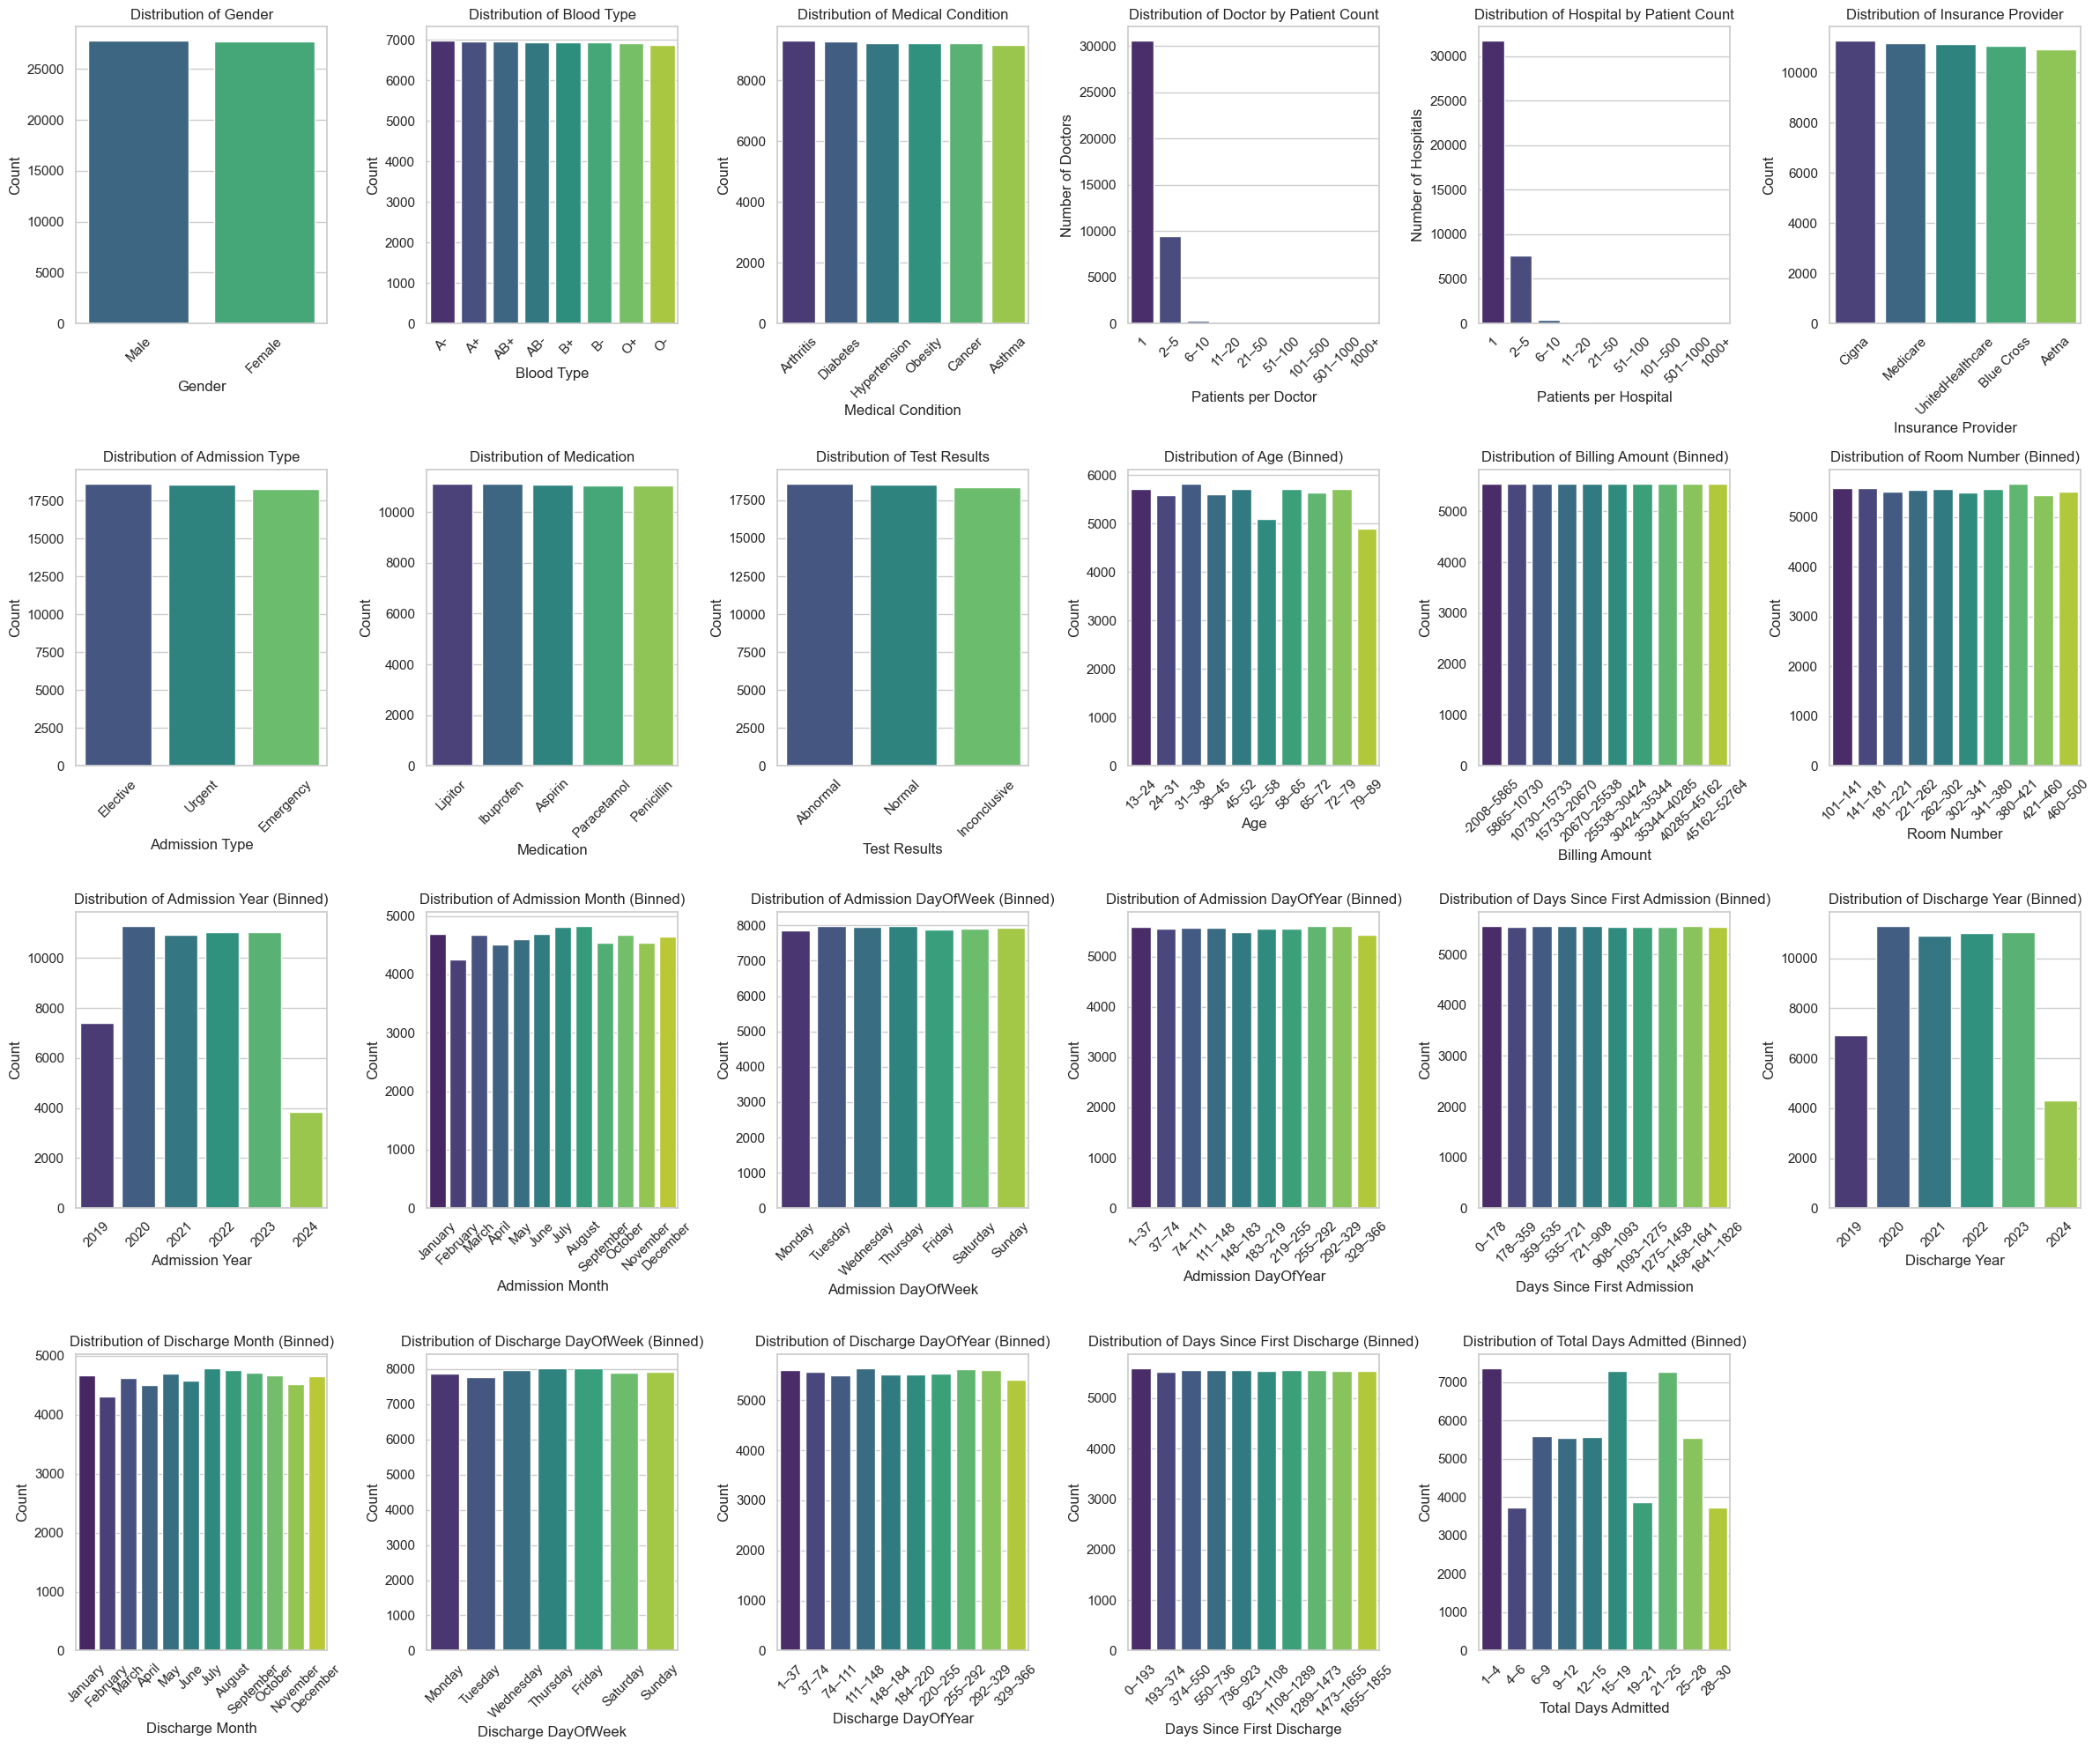

In [107]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
num_cols = df.select_dtypes(include=['number']).columns  # numeric columns to bin

n_cols = 6
n_rows = int(np.ceil((len(cat_cols) + len(num_cols)) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 5 * n_rows))
axes = axes.flatten()

def bin_numeric_series(series, n_bins=10, fixed_bins=None, fixed_labels=None):
    if fixed_bins is not None:
        # Use fixed bins and labels (right=False to have intervals like [a,b))
        return pd.cut(series, bins=fixed_bins, labels=fixed_labels, include_lowest=True, right=False)
    else:
        bins = np.quantile(series.dropna(), np.linspace(0, 1, n_bins + 1))
        bins = np.unique(bins)  # remove duplicates if any quantiles equal
        n_actual_bins = len(bins) - 1
        labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(n_actual_bins)]
        return pd.cut(series, bins=bins, labels=labels, include_lowest=True, duplicates='drop')


year_fixed_bins = [2018.5, 2019.5, 2020.5, 2021.5, 2022.5, 2023.5, 2024.5]
year_fixed_labels = [str(year) for year in range(2019, 2025)]
    
for i, col in enumerate(list(cat_cols) + list(num_cols)):
    if col in ["Doctor", "Hospital"]:
        # Count patients per doctor/hospital
        counts = df.groupby(col).size().reset_index(name="Patient Count")

        # Bin counts for Doctor/Hospital
        max_count = counts["Patient Count"].max()
        bins = [0, 1, 5, 10, 20, 50, 100, 500, 1000, max(max_count + 1, 1001)]
        labels = ["1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–500", "501–1000", "1000+"]

        counts["Bin"] = pd.cut(counts["Patient Count"], bins=bins, labels=labels, right=True)
        bin_counts = counts["Bin"].value_counts().sort_index()

        sns.barplot(
            x=bin_counts.index,
            y=bin_counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} by Patient Count")
        axes[i].set_xlabel(f"Patients per {col}")
        axes[i].set_ylabel(f"Number of {col}s")
        axes[i].tick_params(axis='x', rotation=45)

    elif col in num_cols:
        if col in ['Admission DayOfWeek', 'Discharge DayOfWeek']:
            dayofweek_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            fixed_bins = list(range(0, 8))  # 0 to 7
            fixed_labels = dayofweek_labels
            binned = bin_numeric_series(df[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Month', 'Discharge Month']:
            month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 
                            'July', 'August', 'September', 'October', 'November', 'December']

            fixed_bins = list(range(1, 14))  # 1 to 13, so 12 is included in last bin [12, 13)
            fixed_labels = month_labels
            binned = bin_numeric_series(df[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Year', 'Discharge Year']:
            binned = bin_numeric_series(df[col], fixed_bins=year_fixed_bins, fixed_labels=year_fixed_labels)
        else:
            binned = bin_numeric_series(df[col], n_bins=10)

        counts = binned.value_counts().sort_index()
        sns.barplot(
            x=counts.index.astype(str),
            y=counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} (Binned)")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

    else:
        # For small cardinality categorical variables
        counts = df[col].value_counts().reset_index()
        counts.columns = [col, "Count"]

        sns.barplot(
            x=col,
            y="Count",
            data=counts,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

At first glance, data seems to have balance distributions, apart from patients per doctor and patients per hospital. There are an interesting distribution for total days admitted and age. These should be investigated in latter parts. Discrepancy in admission/discharge year could be due to how the data is sampled. Next, bar plot of billing amount for categorical variables

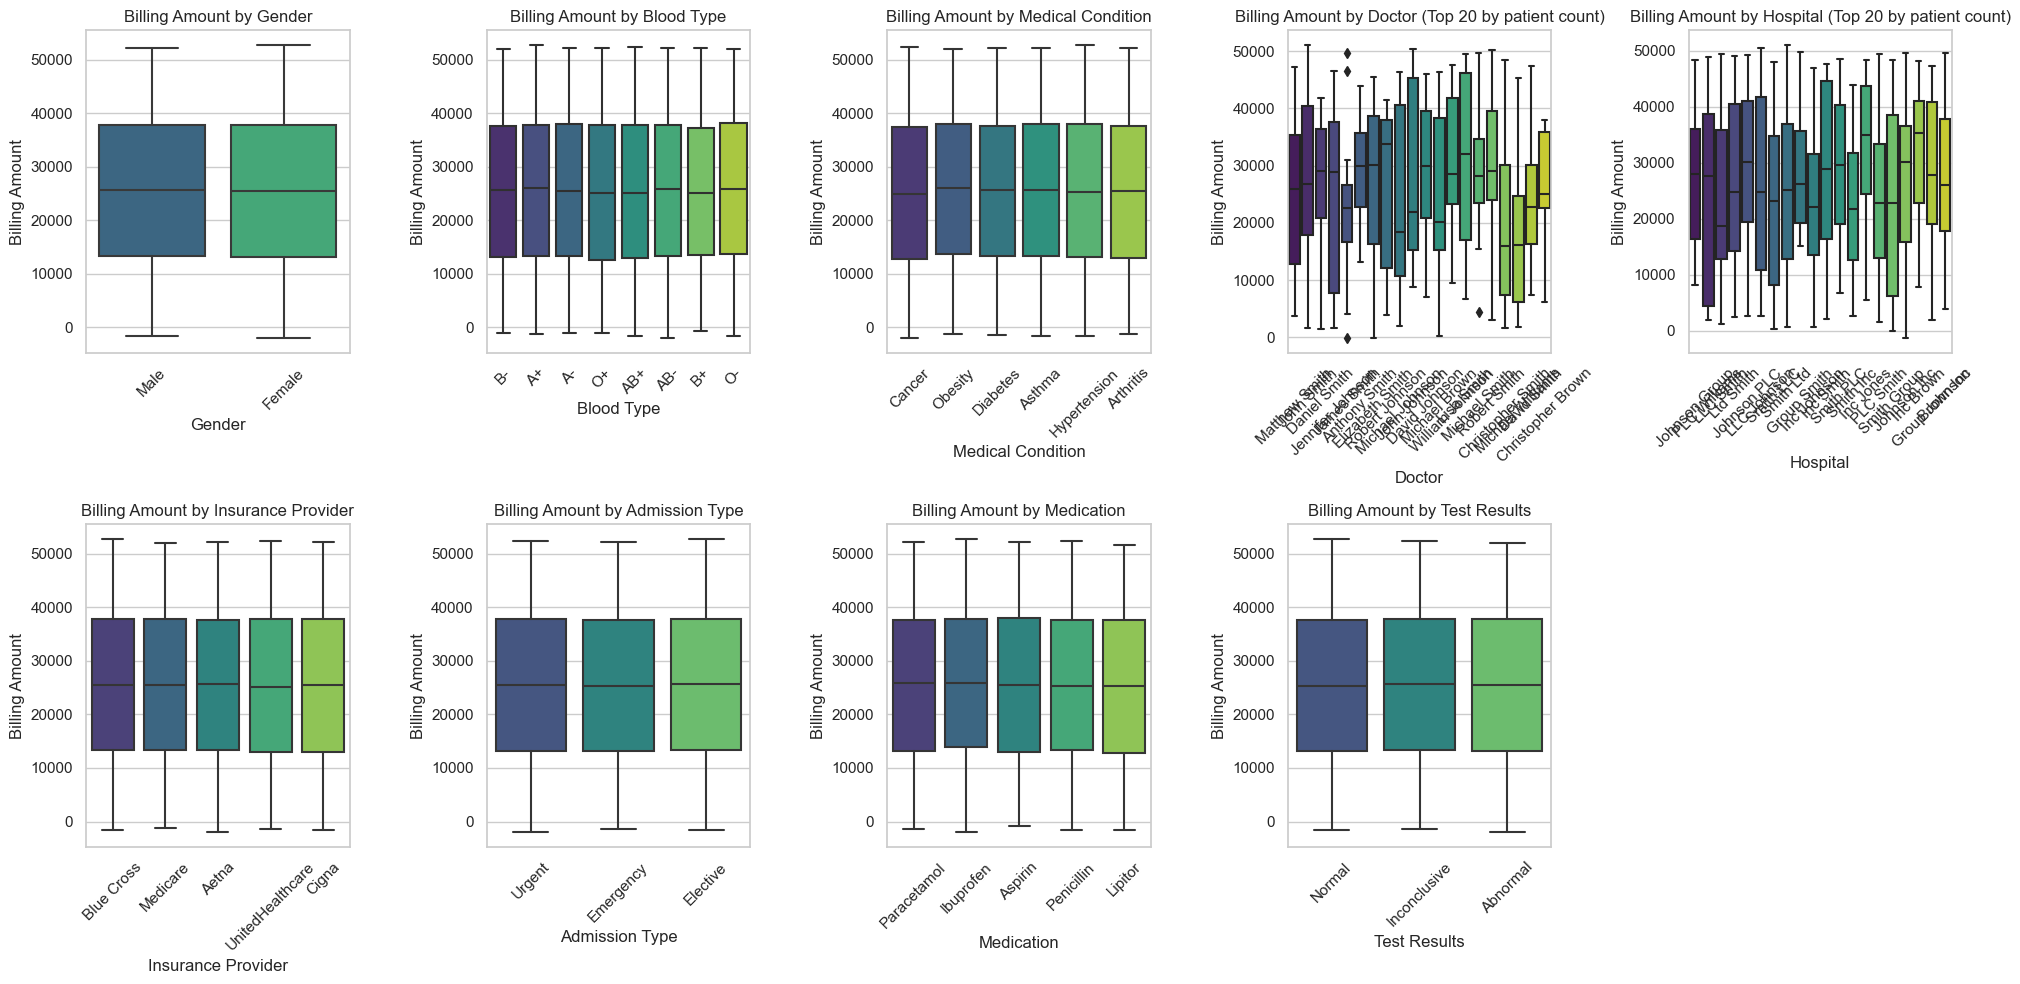

In [108]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

n_cols = 5
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):

    if col in ['Doctor', 'Hospital']:
        # Get top 20 by patient count
        top_20 = (
            df.groupby(col).size()
            .sort_values(ascending=False)
            .head(20)
            .index
            .tolist()
        )
        plot_df = df[df[col].isin(top_20)][[col, 'Billing Amount']].dropna()

        sns.boxplot(x=col, y='Billing Amount', data=plot_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Billing Amount by {col} (Top 20 by patient count)')
    else:
        plot_df = df[[col, 'Billing Amount']].dropna()
        sns.boxplot(x=col, y='Billing Amount', data=plot_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Billing Amount by {col}')

    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Billing Amount')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

For the bar plot alone, there are no visible trends. Lastly, let's check pairplot for numerical values:

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

[]

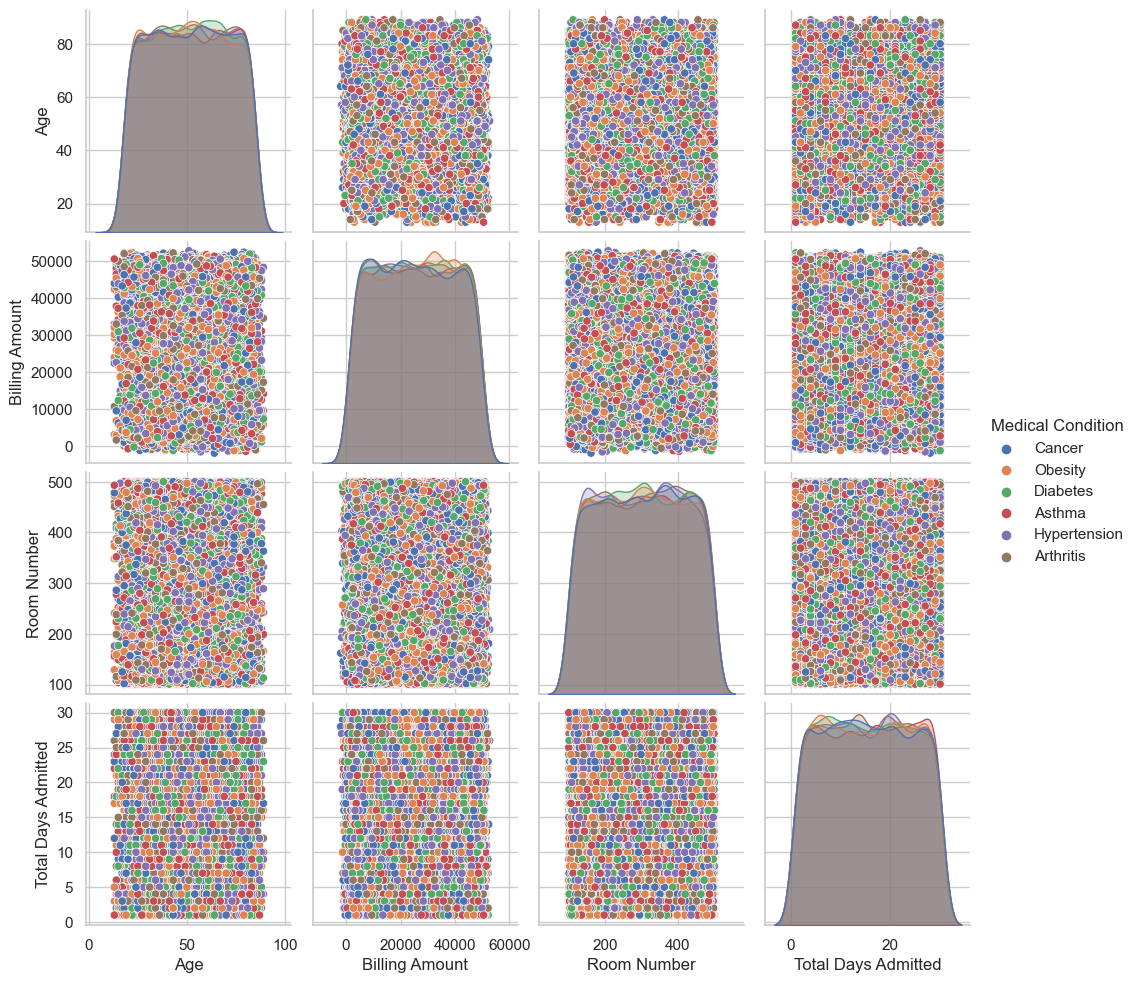

In [109]:
sns.pairplot(df.drop(columns = ['Admission DayOfWeek', 'Discharge DayOfWeek','Admission Year', 'Discharge Year','Admission Month', 'Discharge Month','Admission DayOfYear','Discharge DayOfYear','Days Since First Admission','Days Since First Discharge']), hue = 'Medical Condition')
plt.plot()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

[]

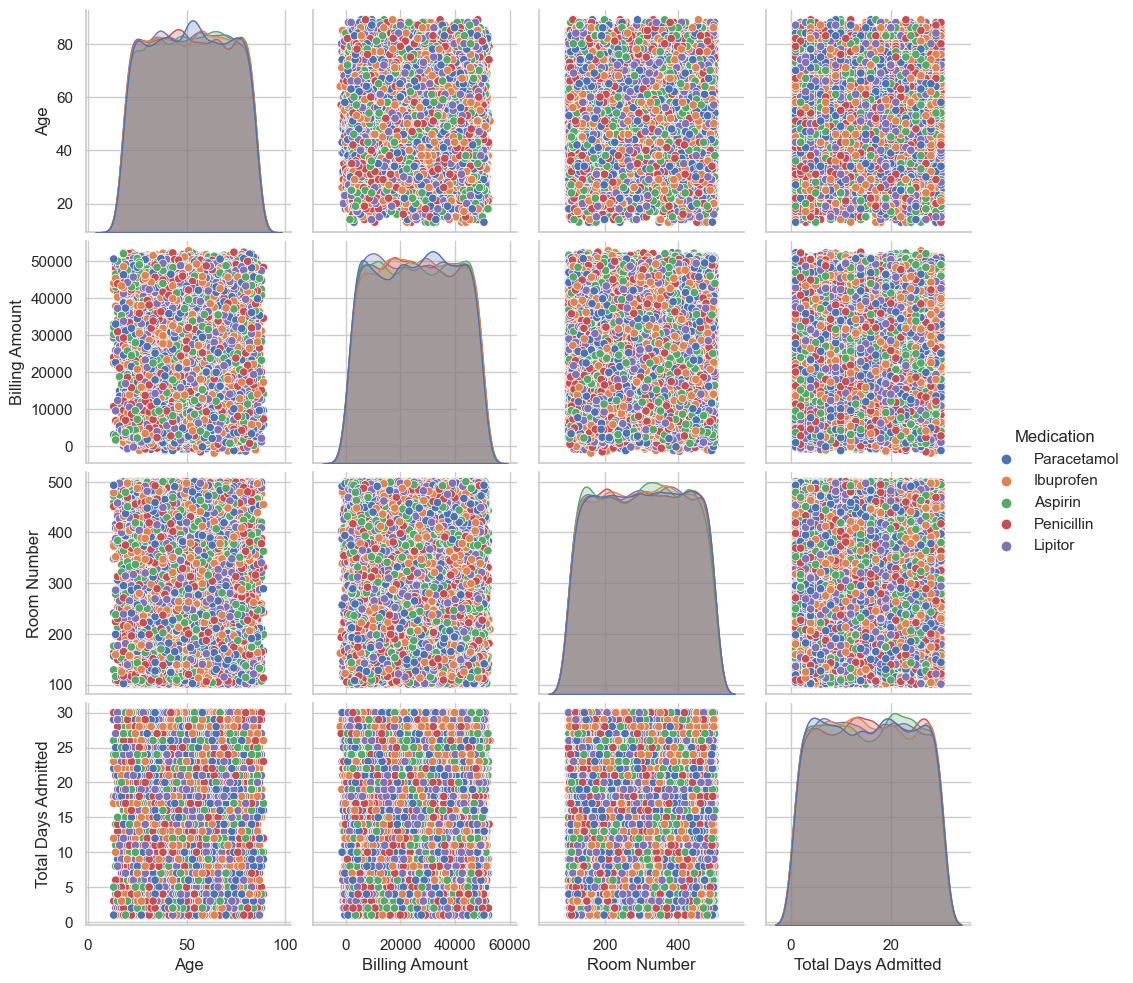

In [110]:
sns.pairplot(df.drop(columns = ['Admission DayOfWeek', 'Discharge DayOfWeek','Admission Year', 'Discharge Year','Admission Month', 'Discharge Month','Admission DayOfYear','Discharge DayOfYear','Days Since First Admission','Days Since First Discharge']), hue = 'Medication')
plt.plot()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

[]

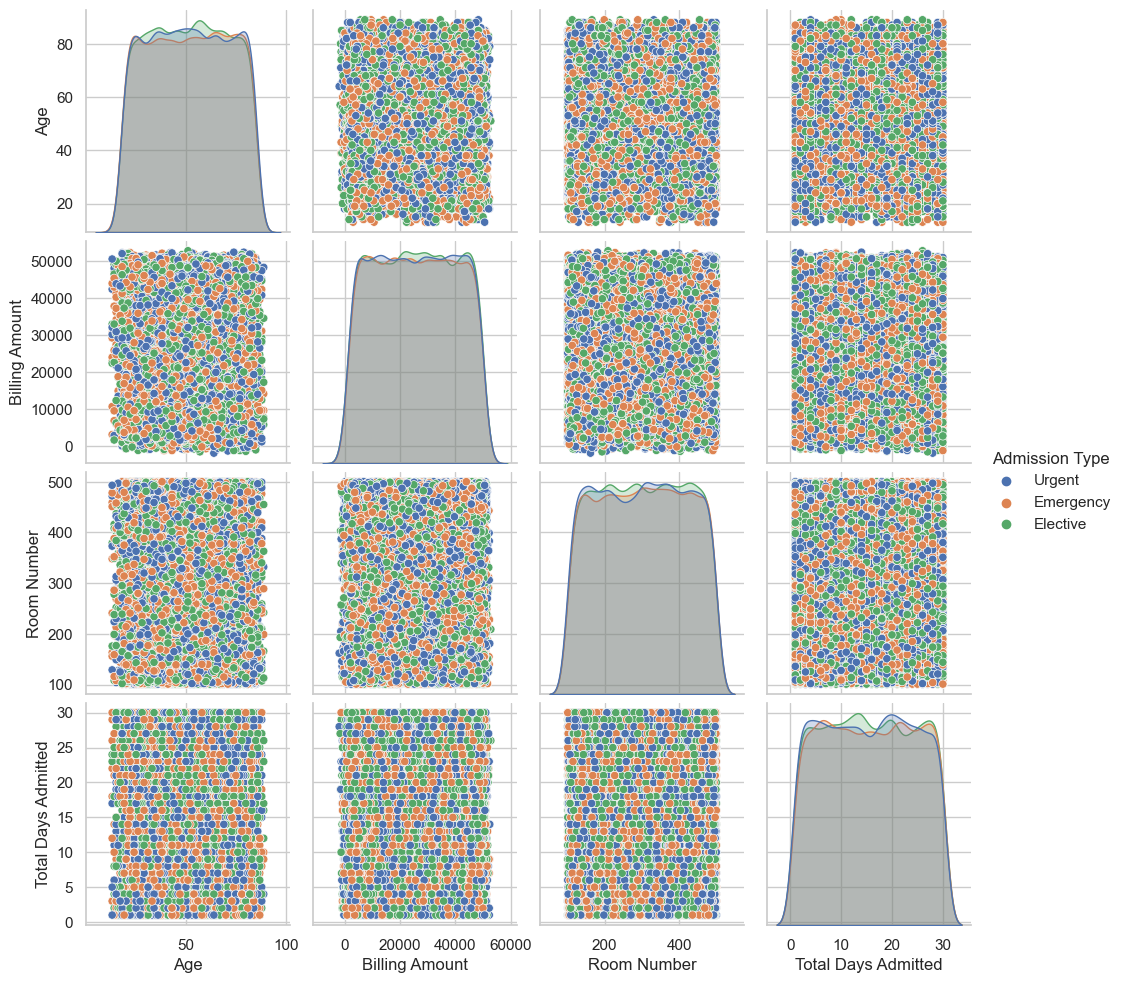

In [111]:
sns.pairplot(df.drop(columns = ['Admission DayOfWeek', 'Discharge DayOfWeek','Admission Year', 'Discharge Year','Admission Month', 'Discharge Month','Admission DayOfYear','Discharge DayOfYear','Days Since First Admission','Days Since First Discharge']), hue = 'Admission Type')
plt.plot()

Still no visible trends for now. Next, let's move on to tests for associations. For numerical values, check correlation:

In [112]:
# Numeric correlation with Billing Amount
print("Correlation (Pearson) with Billing Amount:")
print(df.select_dtypes(include=['number']).corr()['Billing Amount'].sort_values(ascending=False))

Correlation (Pearson) with Billing Amount:
Billing Amount                1.000000
Discharge Month               0.007676
Discharge DayOfYear           0.007321
Admission Month               0.004419
Admission DayOfYear           0.003849
Days Since First Admission   -0.001057
Days Since First Discharge   -0.001149
Admission Year               -0.001763
Discharge Year               -0.002513
Room Number                  -0.002943
Age                          -0.003832
Admission DayOfWeek          -0.003888
Discharge DayOfWeek          -0.004462
Total Days Admitted          -0.005602
Name: Billing Amount, dtype: float64


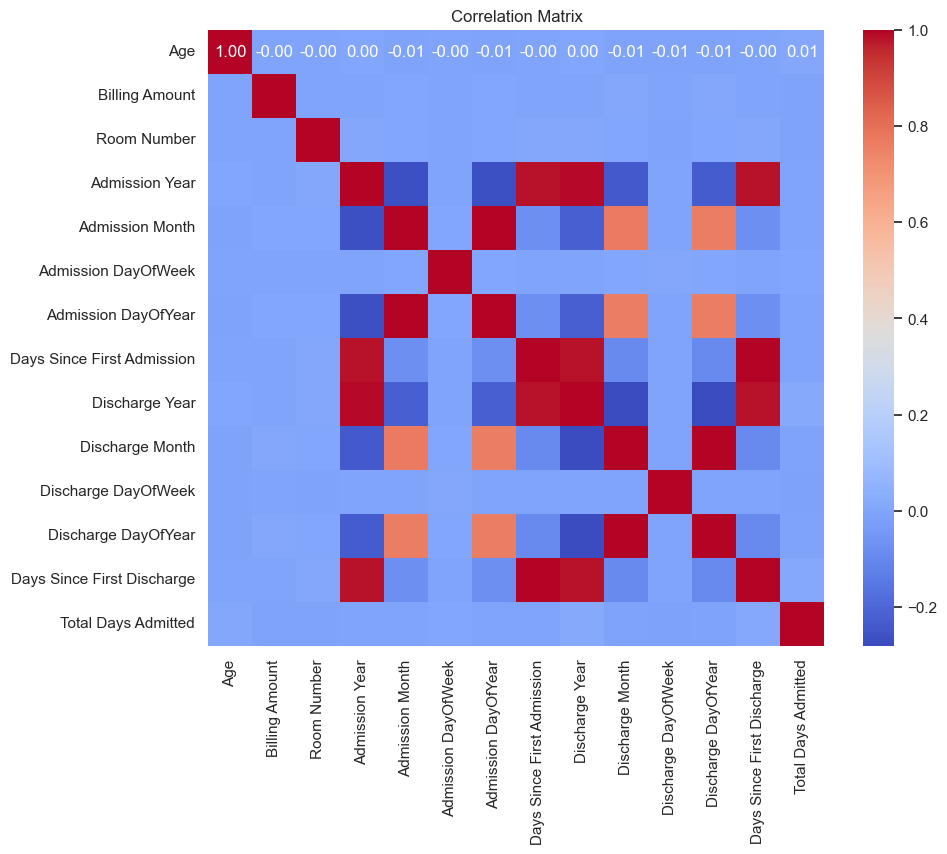

In [113]:
corr_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

I found no significant correlations between billing amount and other numerical variables. Next, the categorical values:

In [114]:
from scipy import stats
import pandas as pd

def get_anova_pvalues(df, cat_cols, target_col='Billing Amount'): # get ANOVA p-value compared to billing amount
    results = {}
    for cat_col in cat_cols:
        groups = [df[df[cat_col] == val][target_col] for val in df[cat_col].dropna().unique()]
        
        if len(groups) < 2:
            results[cat_col] = None  # Not enough groups
            continue
        
        f_stat, p_val = stats.f_oneway(*groups)
        results[cat_col] = p_val
    
    # Convert to DataFrame for easy viewing
    pvalue_df = pd.DataFrame.from_dict(results, orient='index', columns=['ANOVA_p_value'])
    return pvalue_df

# Select categorical columns automatically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Running ANOVA for all categorical values is quite long; thus, I save the calculated value as 'anova_results.csv'
# Folder for saving
save_folder = "saved_results"
os.makedirs(save_folder, exist_ok=True)

filename = os.path.join(save_folder, 'anova_results.csv')

if os.path.exists(filename):
    # Load saved results
    anova_results = pd.read_csv(filename, index_col=0)
    print("Loaded ANOVA results from file.")
else:
    # Compute and save results
    anova_results = get_anova_pvalues(df, categorical_cols)
    anova_results.to_csv(filename)
    print("Computed and saved ANOVA results.")

print(anova_results)


Loaded ANOVA results from file.
                    ANOVA_p_value
Gender               2.554374e-01
Blood Type           3.240196e-01
Medical Condition    5.559198e-02
Doctor              3.219070e-249
Hospital            2.485204e-236
Insurance Provider   7.569849e-01
Admission Type       7.524603e-01
Medication           3.360324e-01
Test Results         5.289806e-01


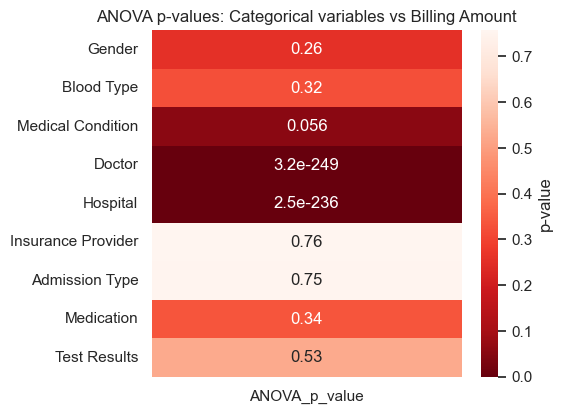

In [115]:
plt.figure(figsize=(5, len(anova_results)*0.5))
sns.heatmap(anova_results[['ANOVA_p_value']], annot=True, cmap='Reds_r', cbar_kws={'label': 'p-value'})
plt.title('ANOVA p-values: Categorical variables vs Billing Amount')
plt.show()


ANOVA test suggest that Doctor and Hospital have a strong association to the patient billing amount under the significance level = 0.05, followed closely by the medical condition under the significant level = 0.1. Next, test for cross associations between categorical variables. However, the very low p-value than usual for Docter and Hospital could be due to the fact that the number of unique doctor and hospital is close to the sample size:

In [116]:
print("Number of unique doctors in this dataset: ", len(df["Doctor"].unique()))
print("Number of unique hospitals in this dataset: ", len(df["Hospital"].unique()))
print("Number of samples in this dataset: ", len(df))

Number of unique doctors in this dataset:  40341
Number of unique hospitals in this dataset:  39876
Number of samples in this dataset:  55500


We can see that there are too many different doctors and hospitals for this dataset. Although ANOVA suggests that Doctor (p ≈ 3.2×10⁻²⁴⁹) and Hospital (p ≈ 2.5×10⁻²³⁶) are statistically extremely significant, the following points should be considered:

- Each category often has very few samples (many possibly only 1–2 patients).
- With 40,000+ categories in a dataset of 55,000 rows, ANOVA will pick up any tiny difference as “significant” — even random noise — simply because the F-test denominator (within-group variance) becomes very small for singleton groups.
- This is likely a cardinality-driven artifact rather than evidence of a meaningful billing trend tied to specific doctors or hospitals.

Furthermore, the observed differences could be due to the fact that different doctors and hospitals handle vastly different cases and patient profiles. The supposed association, if it exists, could be due to confounding variables such as patient condition, admission type, etc.

Therefore, it is reasonable to move on and check the next variables.

In [117]:
# Select categorical columns automatically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
what_to_remove = ['Doctor', 'Hospital']
for item in what_to_remove:
    categorical_cols.remove(item) # Exclusively exclude patient's name, doctor's name, hospital name
print(categorical_cols)

['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']


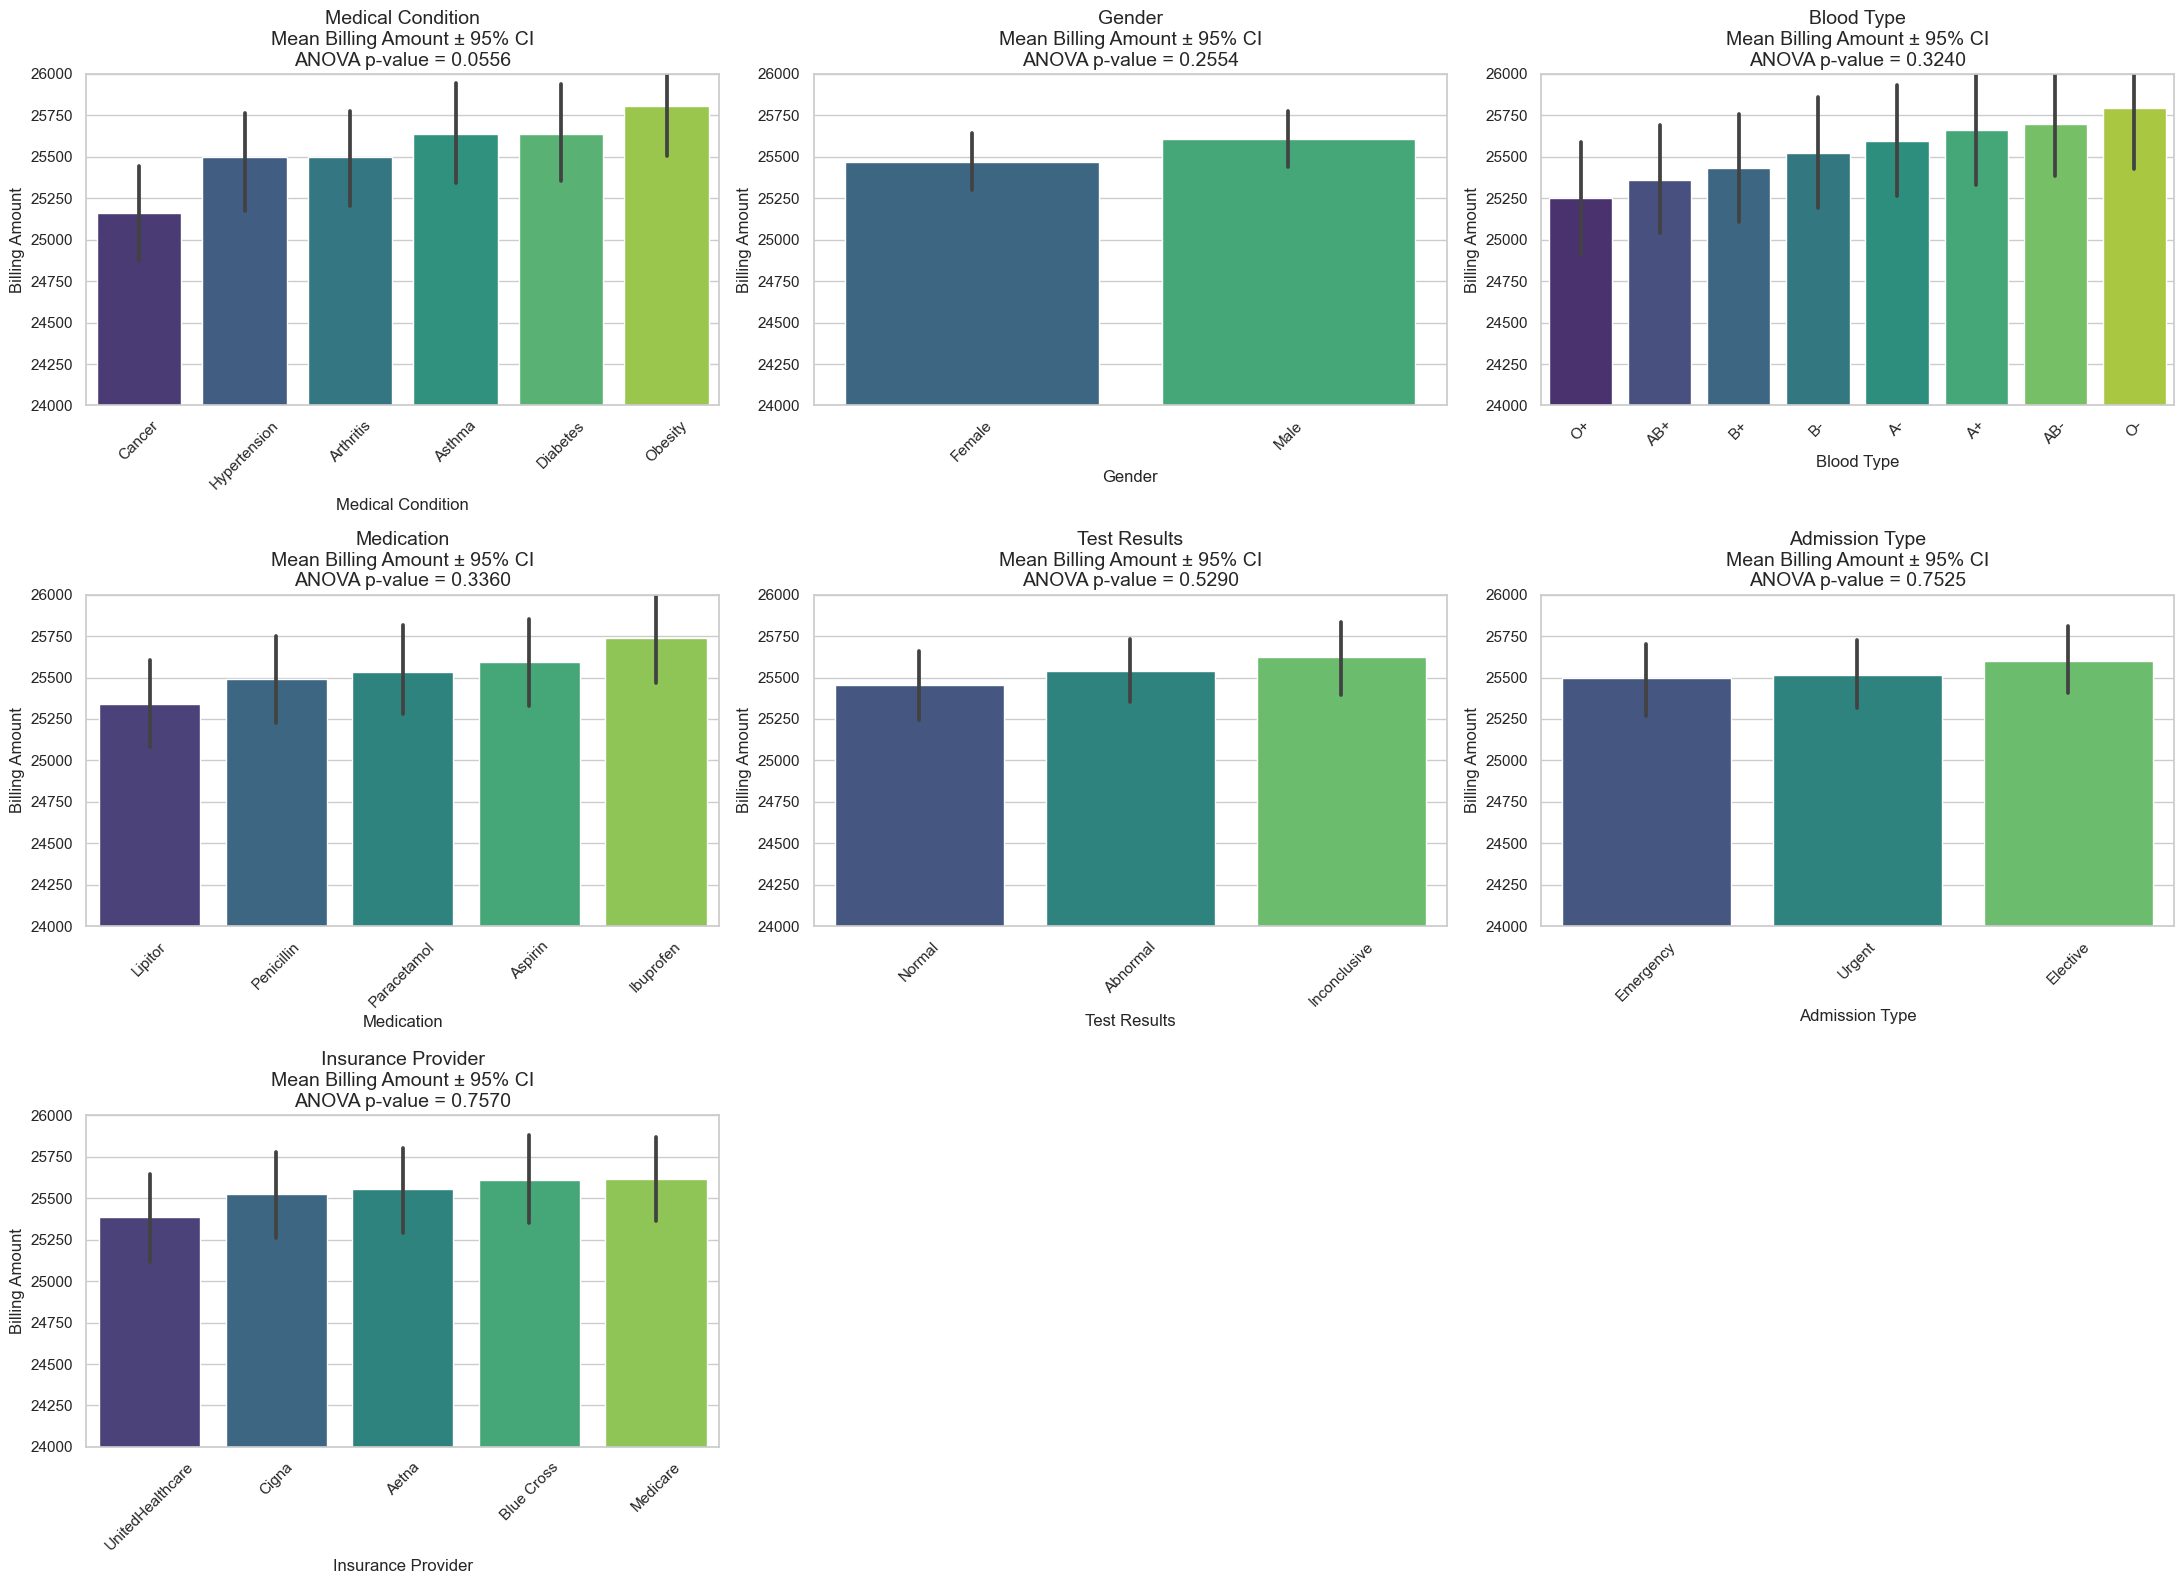

In [118]:
# Sort vars_to_plot by ANOVA p-value
vars_to_plot = [
    "Medical Condition",
    "Gender",
    "Blood Type",
    "Insurance Provider",
    "Admission Type",
    "Medication",
    "Test Results"
]

# Sort vars_to_plot by ANOVA p-value
vars_to_plot_sorted = anova_results.loc[vars_to_plot].sort_values(by="ANOVA_p_value").index.tolist()

sns.set_theme(style="whitegrid")

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(22, 16))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot_sorted):
    # Sort categories by mean billing amount
    order = df.groupby(var)["Billing Amount"].mean().sort_values().index

    p_val = anova_results.loc[var, "ANOVA_p_value"]
    sns.barplot(
        data=df,
        x=var,
        y="Billing Amount",
        order=order,
        errorbar=('ci', 95),
        palette="viridis",
        ax=axes[i]
    )
    
    axes[i].set_title(f"{var}\nMean Billing Amount ± 95% CI\nANOVA p-value = {p_val:.4f}", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(24000, 26000)  # Set y-axis limits here

# Remove unused axes
for j in range(len(vars_to_plot_sorted), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The slight observable trends in **Medical Condition** align with the ANOVA result indicating a potential association with billing amount. Next, I analyze other variables:

1. **Gender, Blood Type, Medication, Test Results** (p-values ≈ 0.25–0.53):  
   - ANOVA indicates no strong statistical evidence of differences in billing amounts across these groups.  
   - However, the distribution plots with 95% confidence intervals show some subtle patterns worth noting.  
   - In practice, any observed associations might be indirect, possibly reflecting underlying links to medical conditions. Therefore, these variables should not be completely dismissed.

2. **Insurance Provider, Admission Type** (high p-values ≈ 0.75):  
   - ANOVA results suggest no meaningful differences in mean billing amounts across categories.  
   - For **Admission Type**, there is a slight increase in billing for elective admissions compared to urgent or emergency cases. This might be confounded by socioeconomic factors, as elective admissions may correlate with wealthier patients.  
   - For **Insurance Provider**, observed trends may reflect differences in customer demographics or other external factors. Given the lack of statistical support, we should refrain from concluding any direct association with billing amounts.


Lastlt, check for observable cross associations:

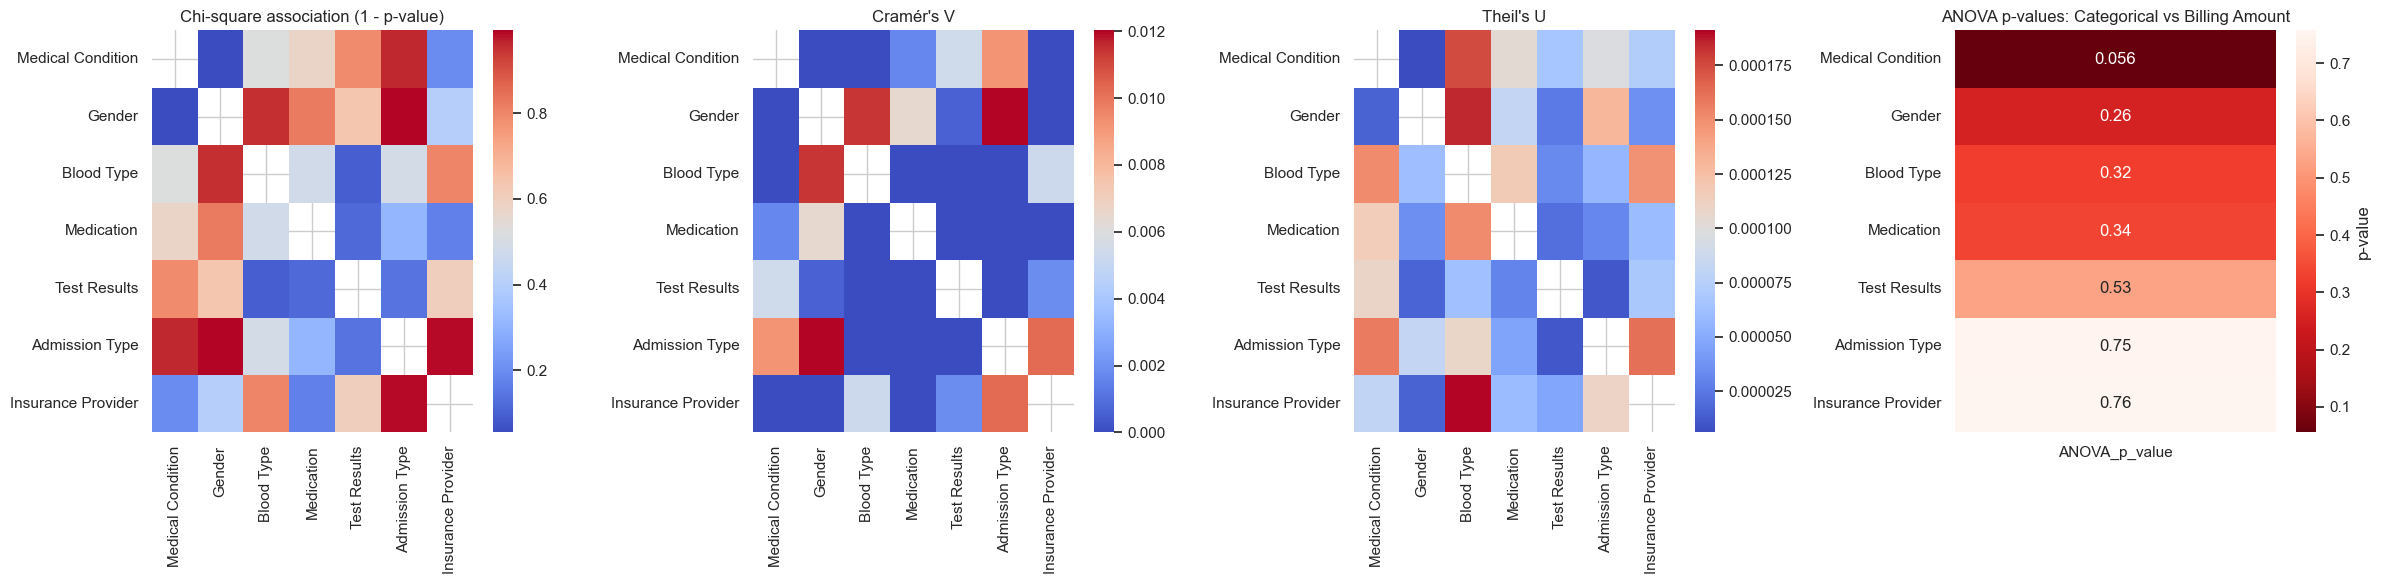

In [119]:
# ======================
# Helper functions (same as your code)
# ======================
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def conditional_entropy(x, y):
    y_counter = y.value_counts()
    xy_counter = pd.crosstab(index=x, columns=y)
    total_occurrences = y_counter.sum()
    entropy = 0.0
    for col in xy_counter.columns:
        p_y = y_counter[col] / total_occurrences
        sub_x = xy_counter[col] / y_counter[col]
        entropy += p_y * -(sub_x[sub_x > 0] * np.log2(sub_x[sub_x > 0])).sum()
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counts = x.value_counts(normalize=True)
    s_x = -(x_counts * np.log2(x_counts)).sum()
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
# ======================
# Main computation
# ======================
def association_matrices(df, categorical_cols):
    chi2_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                               index=categorical_cols, columns=categorical_cols)
    cramers_matrix = chi2_matrix.copy()
    theils_matrix = chi2_matrix.copy()

    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                chi2_matrix.loc[col1, col2] = np.nan
                cramers_matrix.loc[col1, col2] = np.nan
                theils_matrix.loc[col1, col2] = np.nan
            else:
                confusion = pd.crosstab(df[col1], df[col2])
                chi2, p, _, _ = chi2_contingency(confusion)
                chi2_matrix.loc[col1, col2] = p
                cramers_matrix.loc[col1, col2] = cramers_v(confusion)
                theils_matrix.loc[col1, col2] = theils_u(df[col1], df[col2])

    return chi2_matrix, cramers_matrix, theils_matrix

# ======================
# Execution & Sorting
# ======================
anova_results = get_anova_pvalues(df, categorical_cols)

# Sort columns by ascending ANOVA p-value
sorted_cols = anova_results.sort_values(by = 'ANOVA_p_value', ascending=True).index.tolist()

chi2_matrix, cramers_matrix, theils_matrix = association_matrices(df, categorical_cols)

# Reorder matrices by sorted columns (both rows and cols)
chi2_matrix_sorted = chi2_matrix.loc[sorted_cols, sorted_cols]
cramers_matrix_sorted = cramers_matrix.loc[sorted_cols, sorted_cols]
theils_matrix_sorted = theils_matrix.loc[sorted_cols, sorted_cols]

anova_sorted = anova_results.loc[sorted_cols]

# ========= Plotting =========
chi2_scaled = 1 - chi2_matrix_sorted  # Reverse scale for chi2 p-values

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.heatmap(chi2_scaled, annot=False, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Chi-square association (1 - p-value)")

sns.heatmap(cramers_matrix_sorted, annot=False, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Cramér's V")

sns.heatmap(theils_matrix_sorted, annot=False, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Theil's U")

sns.heatmap(anova_sorted, annot=True, cmap='Reds_r', cbar_kws={'label': 'p-value'}, ax=axes[3])
axes[3].set_title('ANOVA p-values: Categorical vs Billing Amount')

plt.tight_layout()
plt.show()


Despite Chi square suggesting cross-association exists, low overall **Cramer's V** and **Theil's U** confirm that such associations are weak and may not be significant.

Therefore, in conclusion, based on the analysis:

1. For the available data, we may conclude that there is the possibility of **9 patients**, each with two admissions, that could be considered follow-ups. Compared to the larger sample of **55,500 patients**, this is negligible, and we may estimate that all admission records are independent for now.

2. **Numerical features**, including one derived from admission and discharged date, show no significant impact on billing amount.

3. While ANOVA suggests that **Doctor** and **Hospital** have a very high impact on billing amounts, these variables must be ruled out due to extremely high cardinality (40,000+ unique categories each) relative to the dataset size. This leads to likely statistical artifacts rather than meaningful effects.

4. Unless additional data or expert domain knowledge becomes available, we also rule out variables with ANOVA p-values approximately between **0.25 and 0.53** as having significant impact on billing amounts.

5. Variables with high ANOVA p-values around **0.75** are also ruled out despite some observable trends because:
   - ANOVA indicates no meaningful differences in mean billing amounts across these categories.
   - For **Admission Type**, the slight increase in billing for elective admissions compared to urgent or emergency cases is likely confounded by socioeconomic factors, as elective admissions may be associated with wealthier patients.
   - For **Insurance Provider**, observed trends may reflect differences in customer demographics or other external influences. Given the lack of statistical evidence, no direct association with billing amount can be confirmed.

6. Cross-association tests using Chi-square, **Cramer's V**, and **Theil's U** confirm that any variable associations are weak and potentially insignificant.

**In summary, the only variable we can currently confirm as impacting billing amount is the _Medical Condition_.**



----
#### Recommendation
Suggest one data-driven recommendation to help the hospital improve: either financial efficiency (e.g., billing, insurance, procedures) or patient care quality (e.g., follow-up plans, medication effectiveness)  

Given the very limited number of potential follow-up cases identified earlier (only 9, and not fully confirmed due to the inability to uniquely identify patients), it is not feasible to draw conclusions or conduct analyses on follow-up care or medication effectiveness. Consequently, I shifted focus to developing recommendations that do not depend on follow-up tracking. As a starting point, I revisited the data distribution, concentrating on total days admitted and patient age, where notable patterns had previously emerged.

In [120]:
# Step 1: Feature selection (drop name and dates for now)
features = df[['Total Days Admitted','Age']].copy()

features.head()


Total Days Admitted  Age
0                    2   30
1                    6   62
2                   15   76
3                   30   28
4                   20   43

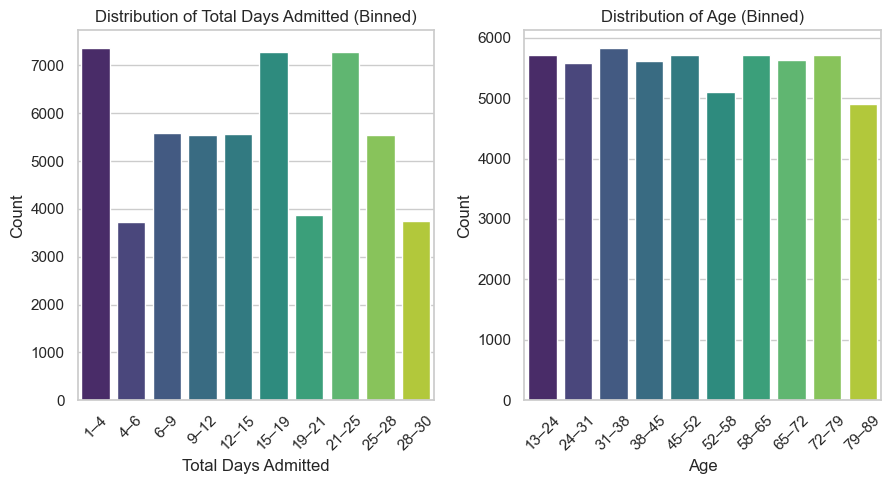

In [121]:
cat_cols = features.select_dtypes(include=['object', 'category']).columns
num_cols = features.select_dtypes(include=['number']).columns  # numeric columns to bin

n_cols = 4
n_rows = int(np.ceil((len(cat_cols) + len(num_cols)) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()


for i, col in enumerate(list(cat_cols) + list(num_cols)):
    if col in ["Doctor", "Hospital"]:
        # Count patients per doctor/hospital
        counts = features.groupby(col).size().reset_index(name="Patient Count")

        # Bin counts for Doctor/Hospital
        max_count = counts["Patient Count"].max()
        bins = [0, 1, 5, 10, 20, 50, 100, 500, 1000, max(max_count + 1, 1001)]
        labels = ["1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–500", "501–1000", "1000+"]

        counts["Bin"] = pd.cut(counts["Patient Count"], bins=bins, labels=labels, right=True)
        bin_counts = counts["Bin"].value_counts().sort_index()

        sns.barplot(
            x=bin_counts.index,
            y=bin_counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} by Patient Count")
        axes[i].set_xlabel(f"Patients per {col}")
        axes[i].set_ylabel(f"Number of {col}s")
        axes[i].tick_params(axis='x', rotation=45)

    elif col in num_cols:
        if col in ['Admission DayOfWeek', 'Discharge DayOfWeek']:
            dayofweek_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            fixed_bins = list(range(0, 8))  # 0 to 7
            fixed_labels = dayofweek_labels
            binned = bin_numeric_series(features[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Month', 'Discharge Month']:
            month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 
                            'July', 'August', 'September', 'October', 'November', 'December']

            fixed_bins = list(range(1, 14))  # 1 to 13, so 12 is included in last bin [12, 13)
            fixed_labels = month_labels
            binned = bin_numeric_series(features[col], fixed_bins=fixed_bins, fixed_labels=fixed_labels)
        elif col in ['Admission Year', 'Discharge Year']:
            binned = bin_numeric_series(features[col], fixed_bins=year_fixed_bins, fixed_labels=year_fixed_labels)
        else:
            binned = bin_numeric_series(features[col], n_bins=10)

        counts = binned.value_counts().sort_index()
        sns.barplot(
            x=counts.index.astype(str),
            y=counts.values,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col} (Binned)")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

    else:
        # For small cardinality categorical variables
        counts = features[col].value_counts().reset_index()
        counts.columns = [col, "Count"]

        sns.barplot(
            x=col,
            y="Count",
            data=counts,
            palette="viridis",
            ax=axes[i]
        )
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Let's find how these affect different group of patients by performing PCA

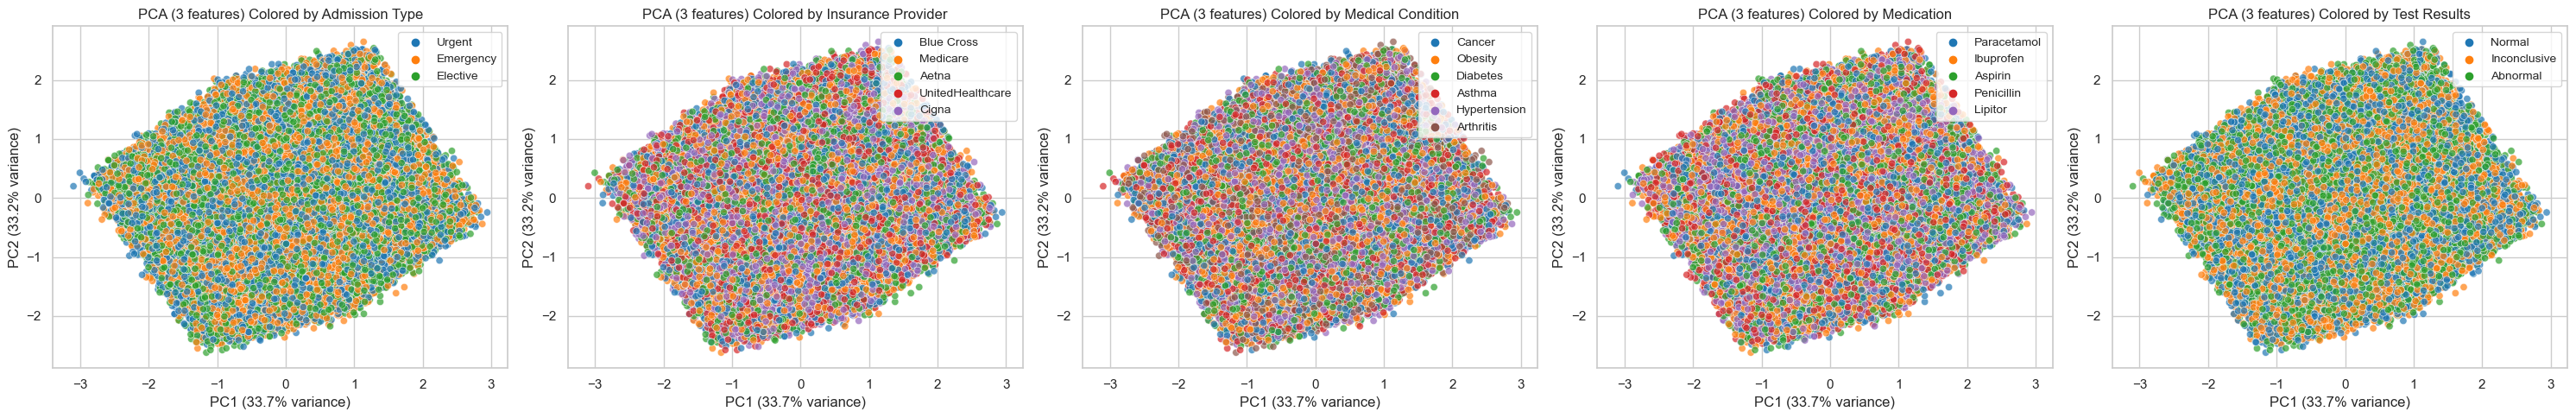

In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

# Features for PCA
features = df[['Total Days Admitted', 'Age', 'Billing Amount']].copy()

# Categorical columns for coloring
categorical_cols = ['Admission Type', 'Insurance Provider', 'Medical Condition', 'Medication', 'Test Results']
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Standardize features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA with 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# DataFrame with PCA results + categorical columns
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
for col in categorical_cols:
    pca_df[col] = df[col]

# Plot PCA scatterplots colored by categories
n_plots = len(categorical_cols)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5), squeeze=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    for i, col in enumerate(categorical_cols):
        ax = axes[0, i]
        sns.scatterplot(
            data=pca_df,
            x='PC1',
            y='PC2',
            hue=col,
            palette='tab10',
            alpha=0.7,
            ax=ax
        )
        ax.set_title(f'PCA (3 features) Colored by {col}')
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
        ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()


Despite interesting distribution, barplots and PCA give us no further insights on how those affects any of the useful categories. Nevertheless, let's try looking at each group averages. I further devide samples by ages and total days admitted by:
- Ages:'Young' (0-18), 'Young Adult' (18-30), 'Adult' (30-50), 'Elder' (50-70), 'Very Elder' (70-120)
- Total Days Admitted: Short and long terms (short ≤7 days, long >7 days)

C:\Users\Tanat\AppData\Local\Temp\ipykernel_53056\830756745.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([cat_col, 'Age_Group', 'Stay_Group']).agg(
C:\Users\Tanat\AppData\Local\Temp\ipykernel_53056\830756745.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([cat_col, 'Age_Group', 'Stay_Group']).agg(
C:\Users\Tanat\AppData\Local\Temp\ipykernel_53056\830756745.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

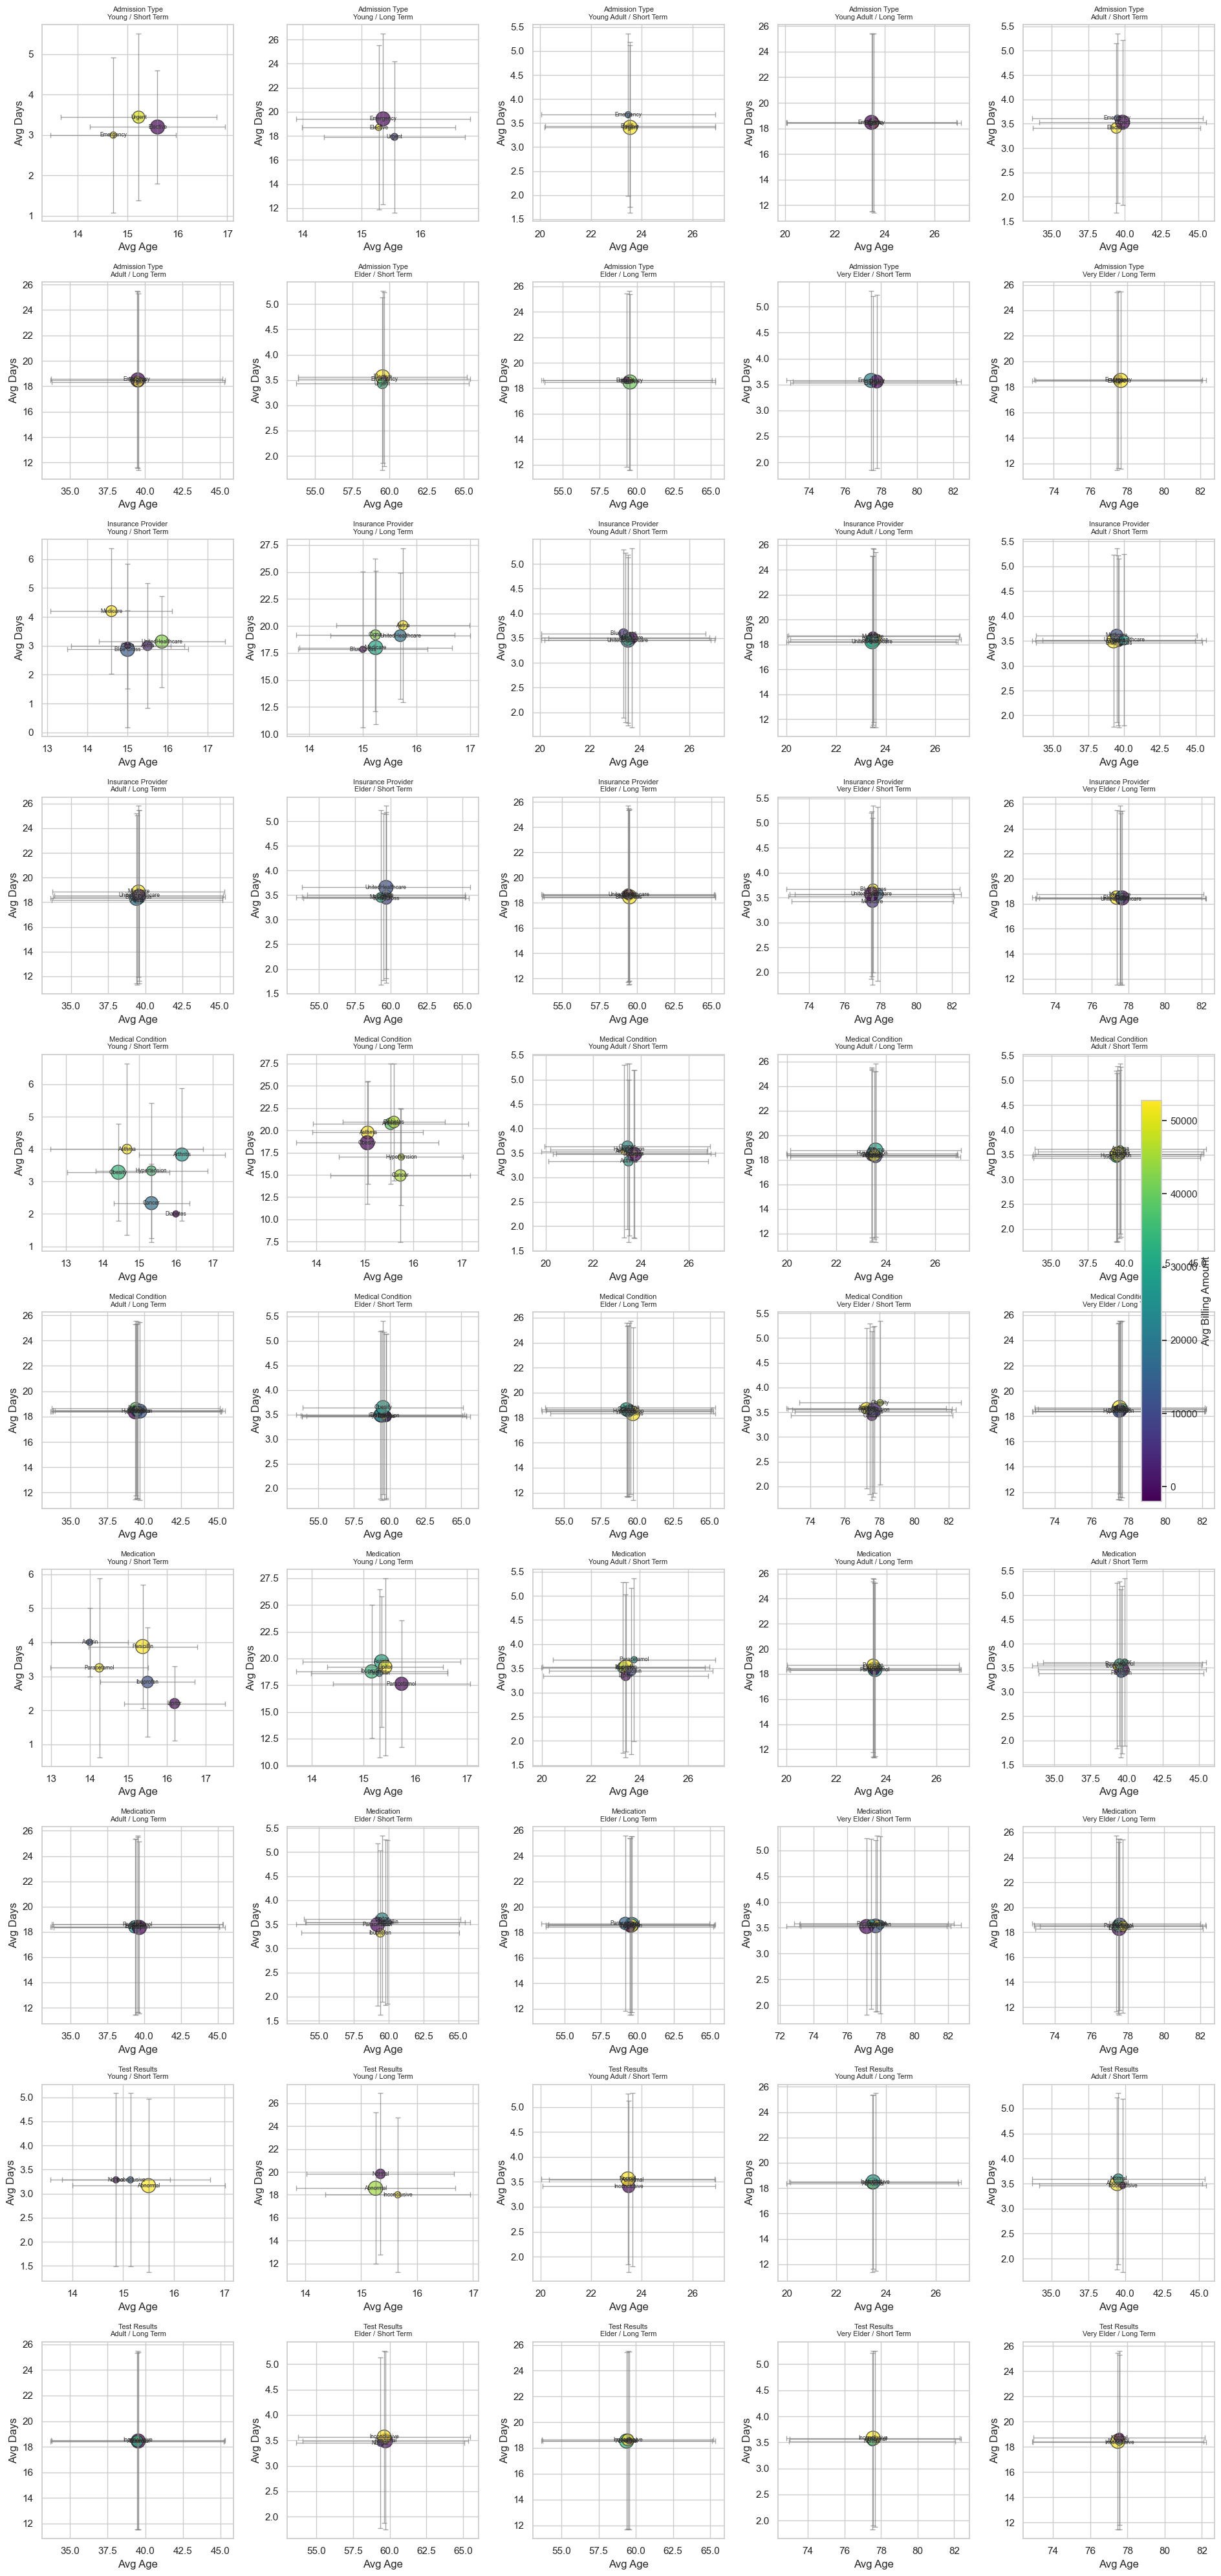

In [123]:
import matplotlib.pyplot as plt
import numpy as np

features = ['Age', 'Total Days Admitted', 'Billing Amount']
categorical_cols = ['Admission Type', 'Insurance Provider', 'Medical Condition', 'Medication', 'Test Results']
categorical_cols = [col for col in categorical_cols if col in df.columns]

age_bins = [0, 18, 30, 50, 70, 120]
age_labels = ['Young', 'Young Adult', 'Adult', 'Elder', 'Very Elder']

stay_bins = [0, 7, df['Total Days Admitted'].max() + 1]  # short ≤7 days, long >7 days
stay_labels = ['Short Term', 'Long Term']

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
df['Stay_Group'] = pd.cut(df['Total Days Admitted'], bins=stay_bins, labels=stay_labels, right=False)

n_cats = len(categorical_cols)
n_ages = len(age_labels)
n_stays = len(stay_labels)
n_subplots = n_cats * n_ages * n_stays

# Layout params
n_cols = 5  # number of columns in figure
n_rows = int(np.ceil(n_subplots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

size_scale = 200

# Flatten axes array for easier indexing
axes_flat = axes.flatten()

plot_idx = 0
for cat_col in categorical_cols:
    # Group by category, age group, and stay group including std for error bars
    grouped = df.groupby([cat_col, 'Age_Group', 'Stay_Group']).agg(
        mean_age=('Age', 'mean'),
        std_age=('Age', 'std'),
        mean_days=('Total Days Admitted', 'mean'),
        std_days=('Total Days Admitted', 'std'),
        mean_billing=('Billing Amount', 'mean'),
        count=(cat_col, 'size')
    ).reset_index()

    for age_group in age_labels:
        for stay_group in stay_labels:
            ax = axes_flat[plot_idx]
            plot_idx += 1

            subgrp = grouped[
                (grouped['Age_Group'] == age_group) & 
                (grouped['Stay_Group'] == stay_group)
            ]

            if subgrp.empty:
                ax.set_visible(False)
                continue

            counts = subgrp['count'].fillna(0)
            sizes = (counts - counts.min()) / (counts.max() - counts.min() + 1e-9) * size_scale + 50

            # Scatter points
            scatter = ax.scatter(
                subgrp['mean_age'],
                subgrp['mean_days'],
                s=sizes,
                c=subgrp['mean_billing'],
                cmap='viridis',
                alpha=0.7,
                edgecolor='k'
            )

            # Add error bars for Age (x) and Total Days Admitted (y)
            ax.errorbar(
                subgrp['mean_age'],
                subgrp['mean_days'],
                xerr=subgrp['std_age'],
                yerr=subgrp['std_days'],
                fmt='none',
                ecolor='gray',
                alpha=0.7,
                capsize=3,
                linewidth=1
            )

            # Add labels
            for _, row in subgrp.iterrows():
                label = str(row[cat_col])
                ax.text(row['mean_age'], row['mean_days'], label, fontsize=6, ha='center', va='center')

            ax.set_title(f'{cat_col}\n{age_group} / {stay_group}', fontsize=8)
            ax.set_xlabel('Avg Age')
            ax.set_ylabel('Avg Days')

# Hide any remaining unused axes
for i in range(plot_idx, len(axes_flat)):
    axes_flat[i].set_visible(False)

# Add colorbar for billing amount (shared across all)
norm = plt.Normalize(vmin=df['Billing Amount'].min(), vmax=df['Billing Amount'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Avg Billing Amount')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


We see some workable patterns emerges among young patients; thus, let's focus on this age group.

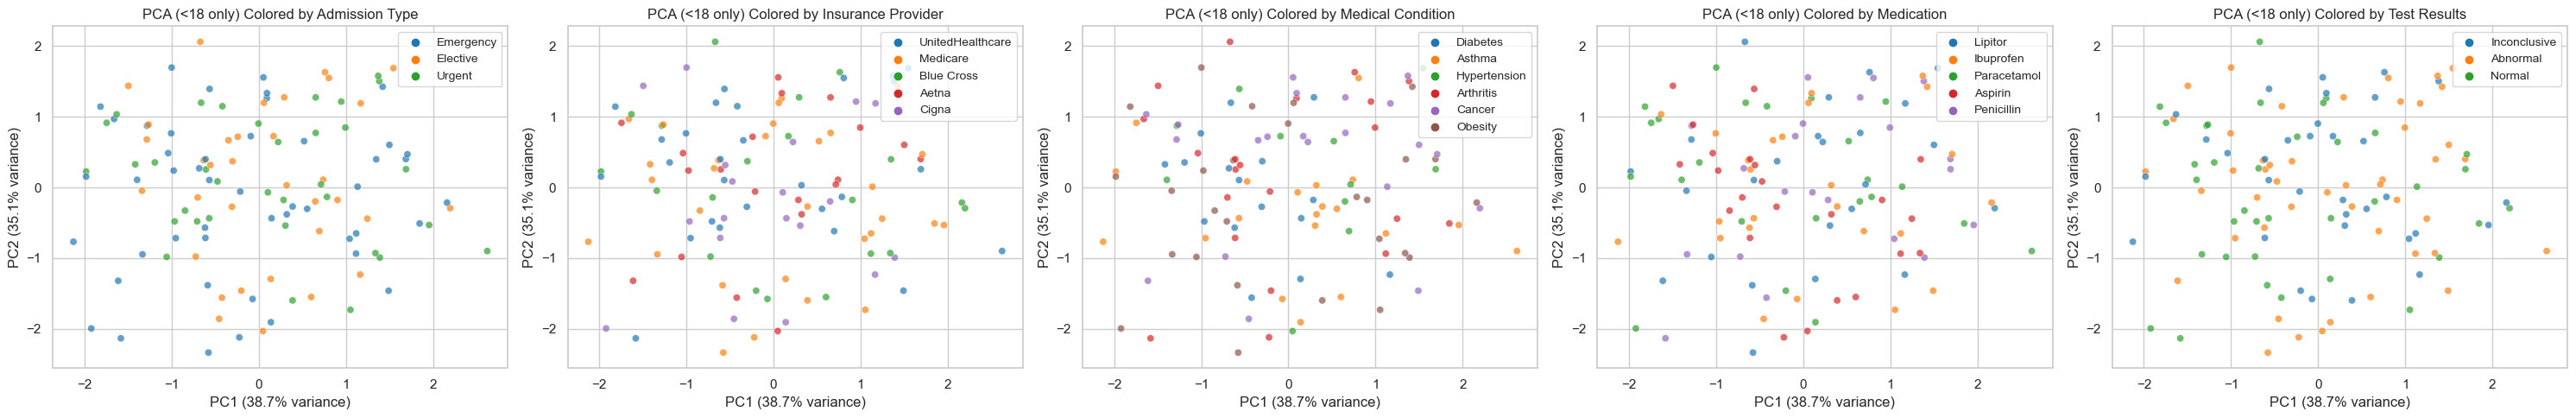

In [124]:
# Filter patients with age < 18
df_under18 = df[df['Age'] < 18].copy()

# Features for PCA
features = df_under18[['Total Days Admitted', 'Age', 'Billing Amount']].copy()

# Categorical columns for coloring
categorical_cols = ['Admission Type', 'Insurance Provider', 'Medical Condition', 'Medication', 'Test Results']
categorical_cols = [col for col in categorical_cols if col in df_under18.columns]

# Standardize features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA with 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# DataFrame with PCA results + categorical columns
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
for col in categorical_cols:
    pca_df[col] = df_under18[col].values

# Plot PCA scatterplots colored by categories
n_plots = len(categorical_cols)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5), squeeze=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    for i, col in enumerate(categorical_cols):
        ax = axes[0, i]
        sns.scatterplot(
            data=pca_df,
            x='PC1',
            y='PC2',
            hue=col,
            palette='tab10',
            alpha=0.7,
            ax=ax
        )
        ax.set_title(f'PCA (<18 only) Colored by {col}')
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
        ax.legend(loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()
